# A comparative analysis of wind speed data in two locations with a view to determining the best site for construction of a new windfarm
In this project, I perform a comparative data analysis between two locations: Gurteen in Tipperary and Ballyhaise in Cavan. For the purposes of this assignment, I have imagined myself in the role of a data analyst who has been employed by a wind farm contractor to determine the best of two sites for the construction of a new wind farm. The contractor has two sites in two different locations (Gurteen in Tipperary and Ballyhaise in Cavan), both sitting at approx. 75m above sea level. I analyse historical Met Eireann data for two stations (Gurteen and Athenry) to determine which of the two locations is best for the construction of a new wind farm.

## Met Eireann Data
For each of the two locations, there is data on wind speeds dating back to 2010. I downloaded the monthly data for each station.

In first of the two code cells below, I import the necessary libraries for my analysis.

In the second of the two code cells below I import the two csv files, one relating to the Gurteen weather station data and one relating to the Ballyhaise weather station data.







In [122]:
import pandas as pd
from prophet import Prophet

In [123]:
# below I use the Pandas.read_csv function to read in both csv files, skippiing the first 19 rows of metadata

ballyhaise_data = pd.read_csv("data/mly675.csv", skiprows=19)
gurteen_data = pd.read_csv("data/mly1475.csv", skiprows=19)

In [124]:
# below I display the first 5 rows of each dataframe to verify that the data has been read in correctly

#print(ballyhaise_data.head())
#print(gurteen_data.head())

# dropping unnecessary columns from both dataframes, and shortening time period to last 10 years
ballyhaise_data = ballyhaise_data.drop(columns=['rain', 'meant', 'maxtp', 'mintp', 'mnmax', 'mnmin', 'gmin', 'sun'])
gurteen_data = gurteen_data.drop(columns=['rain', 'meant', 'maxtp', 'mintp', 'mnmax', 'mnmin', 'gmin', 'sun'])

# converting the index values to integers so that I can filter by year
ballyhaise_data['year'] = ballyhaise_data['year'].astype(int)
gurteen_data['year'] = gurteen_data['year'].astype(int)

# I've added .copy() to the end of the lines below to avoid SettingWithCopyWarning messages
ballyhaise_10yr = ballyhaise_data[ballyhaise_data['year'] >= 2014].copy()
gurteen_10yr = gurteen_data[gurteen_data['year'] >= 2014].copy()

print(ballyhaise_10yr.head())
print(gurteen_10yr.head())

     year  month wdsp  maxgt
111  2014      1  7.8     45
112  2014      2  9.8     47
113  2014      3  7.3     38
114  2014      4  6.5     38
115  2014      5  5.7     31
    year  month  wdsp  maxgt
70  2014      1  10.5     49
71  2014      2  12.8     65
72  2014      3   9.0     42
73  2014      4   8.4     32
74  2014      5   7.7     36


In [125]:
# before moving onto my analysis, I will quickly clean up the wdsp data by replacing any missing values with the overall mean value wdsp

# the values in the wdsp column are currently registering as strings rather than a numerical type such as int or float, so I will convert them to floats first
ballyhaise_10yr['wdsp'] = pd.to_numeric(ballyhaise_10yr['wdsp'], errors='coerce')
gurteen_10yr['wdsp'] = pd.to_numeric(gurteen_10yr['wdsp'], errors='coerce')


# now I will fill in empty values with the mean wdsp
ballyhaise_10yr['wdsp'] = ballyhaise_10yr['wdsp'].fillna(ballyhaise_10yr['wdsp'].mean())
gurteen_10yr['wdsp'] = gurteen_10yr['wdsp'].fillna(gurteen_10yr['wdsp'].mean())

In the code cell below, I begin my analysis by asking which of the two locations had the highest mean wind speed over the past 10 years, provided that mean is within the optimal range for wind farm function. According to [this article](https://businessnorway.com/articles/wind-speed-for-wind-turbines-unlocking-optimal-output), the optimal wind speed for wind farms is between 4 m/s and 12 m/s. Below I get the mean wind speed for each area over the past 10 years and assess firstly whether it sits within this optimal range, and secondly which area's wind speed is higher.

I convert values in the wdsp column, which are measurements in knots, into metres per second by dividing by 1.944, and store these in a new column called 'wdsp_m/s'.

In [126]:
# firstly, I create a new column with the speed in m/s, converted from knots

ballyhaise_10yr['wdsp_m/s'] = ballyhaise_10yr['wdsp'] / 1.944
gurteen_10yr['wdsp_m/s'] = gurteen_10yr['wdsp'] / 1.944

ballyhaise_10yr_mean = ballyhaise_10yr['wdsp_m/s'].mean()
gurteen_10yr_mean = gurteen_10yr['wdsp_m/s'].mean()

print(ballyhaise_10yr_mean)
print(gurteen_10yr_mean)

3.151529540418429
4.231416731416731


The initial result shows that the Ballyhaise area has lower mean wind speed in m/s at 3.12. The Gurteen area has a mean wind speed in m/s of 4.2.

So initially it would seem that Gurteen would be the best choice for the construction of a new windfarm. Next I want to know what the highest mean windspeed was for each windfarm, with a view to informing what size of wind farm and wind turbine is most suitable.

In [127]:
top_wdsp_ballyhaise = ballyhaise_10yr['wdsp_m/s'].max()
top_wdsp_gurteen = gurteen_10yr['wdsp_m/s'].max()

print(top_wdsp_ballyhaise)
print(top_wdsp_gurteen)

5.041152263374486
6.841563786008231


On average, then, we can see that neither windfarm has ever exceeded on average in any month in the past 10 years windspeeds that would cause the turbines to shut down. We can also see that again Gurteen has achieved the highest mean monthly windspeed of the two areas, although there isn't an enormous difference.

Next, I'll create a datetime column from the year and month columns in the datasets, so that I can plot a graph forecasting how windspeeds are likely to change in the next 10 years in both areas.

In [128]:
# adding a datetime column to both datasets for easier plotting later on
ballyhaise_10yr['date'] = pd.to_datetime(ballyhaise_10yr[['year', 'month']].assign(day=1))

ballyhaise_10yr.head()

gurteen_10yr['date'] = pd.to_datetime(gurteen_10yr[['year', 'month']].assign(day=1))

gurteen_10yr.head()

,year,month,wdsp,maxgt,wdsp_m/s,date
70,2014,1,10.5,49,5.401235,2014-01-01
71,2014,2,12.8,65,6.584362,2014-02-01
72,2014,3,9.0,42,4.629630,2014-03-01
73,2014,4,8.4,32,4.320988,2014-04-01
74,2014,5,7.7,36,3.960905,2014-05-01


Next I use the time series forecasting library Prophet to predict windspeeds for the next 10 years in both locations. I followed [this online tutorial](https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet) in order to do this with the Ballyhaise and Gurteen datasets.

Prophet needs the dataset to have two columns 'ds' and 'y' corresponding to the time series data and values respectively, so I quickly update my dataframes to meet this requirement first.

14:08:11 - cmdstanpy - INFO - Chain [1] start processing
14:08:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\fmtie\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


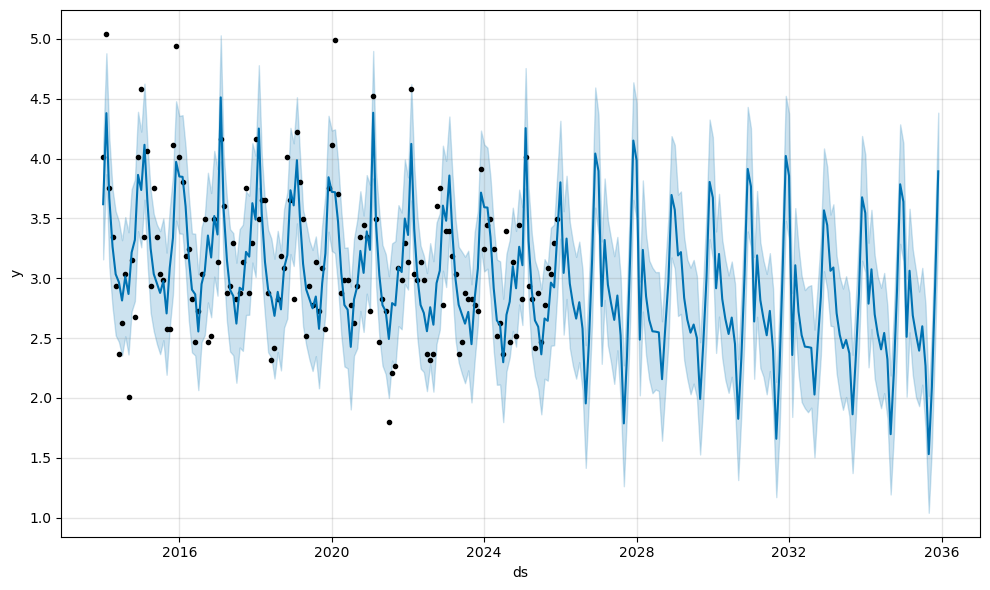

In [129]:
# preparing the ballyahise model

ballyhaise_10yr = ballyhaise_10yr.rename(columns={'date': 'ds', 'wdsp_m/s': 'y'})

ballyhaise_model = Prophet()
ballyhaise_model.fit(ballyhaise_10yr[['ds', 'y']])

# using prophet to generate a dataframe of future dates for prediction - here I am generating dates for the next 120 months (10 years)
future_dates = ballyhaise_model.make_future_dataframe(periods=120, freq='M')
future_dates.tail()

ballyhaise_forecast = ballyhaise_model.predict(future_dates)
# displaying the forecasted values, leaving out unnecessary columns as instructed in Kaggle tutorial
ballyhaise_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# according to the Kaggle tutorial, the 'yhat' column contains the predicted wind speeds for the future dates, so I will plot just the yhat values against the dates for now
ballyhaise_10yr_fig = ballyhaise_model.plot(ballyhaise_forecast)

Above we can see a predicted trend in wind speeds in m/s in the Ballyhaise area. According to the Prophet model, wind speeds seem to trend downwards overall over the next 10 years.

I will now prepare the same plot for the Gurteen area to see how it compares.

14:08:12 - cmdstanpy - INFO - Chain [1] start processing
14:08:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\fmtie\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


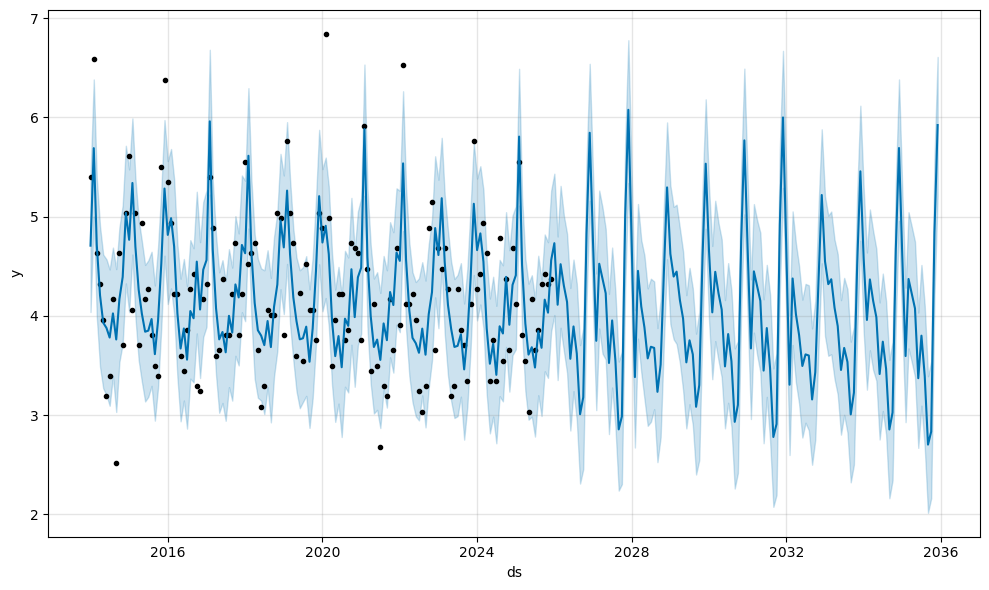

In [130]:
# preparing the gurteen model

gurteen_10yr = gurteen_10yr.rename(columns={'date': 'ds', 'wdsp_m/s': 'y'})

gurteen_model = Prophet()
gurteen_model.fit(gurteen_10yr[['ds', 'y']])

# using prophet to generate a dataframe of future dates for prediction - here I am generating dates for the next 120 months (10 years)
future_dates = gurteen_model.make_future_dataframe(periods=120, freq='M')
future_dates.tail()

gurteen_forecast = gurteen_model.predict(future_dates)
# displaying the forecasted values, leaving out unnecessary columns as instructed in Kaggle tutorial
gurteen_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# according to the Kaggle tutorial, the 'yhat' column contains the predicted wind speeds for the future dates, so I will plot just the yhat values against the dates for now
gurteen_10yr_fig = gurteen_model.plot(gurteen_forecast)

In the above prediction plot for the Gurteen area, there is not as obvious a downward trend as in the case of Ballyhaise. The seasonal spikes in wind speed are still quite high into 2035 at monthly means of roughly between 5 and 6 m/s, compared with Ballyhaise where they get down to between 3.5 and 4 m/s between 2032 and 2036.